SMS Spam/Ham dataset.
1(+6). Проверить, сбалансирован ли датасет (может быть, наблюдений одного класса слишком много?). Какие результаты покажет dummy classifier, который будет всем новым наблюдениям присваивать класс ham? Насколько плохо такое решение для задачи определения спама?
Грубое решение - включить в training set только необходимое число наблюдений (примерно поровну spam и ham). 
Нормализовать тексты и обучить байесовскую модель (bag of words). Проверить, как влияют на результат:
1) разная токенизация: в одном случае знаки препинания удалять, в другом — считать их токенами;
2) лемматизация (отсутствие лемматизации, стемминг, лемматизация; инструменты можно использовать любые, например, nltk.stem);
3) удаление стоп-слов, а также пороги минимальной и максимальной document frequency;
4) векторизация документов (CountVectorizer vs. TfIdfVectorizer);
5) что-нибудь ещё?
При оценке классификатора обратите внимание на TP и FP.

Extra: ограничив количество наблюдений ham в обучающей выборке, мы игнорируем довольно много данных. 1) В цикле: случайно выбрать нужное число писем ham и сконструировать сбалансированную выборку, построить классификатор, оценить и записать результат; в итоге результаты усреднить. 2) поможет ли параметр class prior probability?


2(+2). Сравнить результаты байесовского классификатора, решающего дерева и RandomForest. Помимо стандартных метрик оценки качества модели, необходимо построить learning curve, ROC-curve, classification report и интерпретировать эти результаты.

3(+2). А что, если в качестве предикторов брать не количество вхождений слов, а конструировать специальные признаки? Прежде всего, необходимо разделить таблицу на training set и test set в соотношении 80:20, test set не открывать до этапа оценки модели. С помощью pandas проверить, отличаются ли перечисленные ниже параметры (иможно придумать другие) для разных классов (spam/ham), и собрать матрицу признаков для обучения. Примеры признаков: длина сообщения, количество букв в ВЕРХНЕМ РЕГИСТРЕ, восклицательных знаков, цифр, запятых, каких-то конкретных слов (для этого можно построить частотный словарь по сообщениям каждого класса). Прокомментировать свой выбор. Векторизовать документы и построить классификатор. Оценить модель на проверочной выборке.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

messages = pd.read_csv('./smsspamcollection/SMSSpamCollection',
                           sep='\t',
                           names=["label", "message"])
print(messages.groupby('label').describe())

                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


видно, что данные очень несболлансированные,для баллансировки, увеличим коичество spam в 4 раза, просто доавляя по три копии предложения, чтобы не "резать" и не сокращать dataset. Потом делим данные на трейн и тест.

In [2]:
#balansing the data
balansed_messages_ = messages.append(messages[messages.label == 'spam'], ignore_index=True)
balansed_messages = balansed_messages_.append(balansed_messages_[balansed_messages_.label == 'spam'], ignore_index=True)
print(balansed_messages.groupby('label').describe())
#print(balansed_messages.loc[4680])

                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                2988
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                   16


In [3]:
#X, y = balansed_messages['message'], balansed_messages['label']
train, test = train_test_split(balansed_messages,
         test_size=0.2, random_state=42)
#print(train)

Переберем все возможные комбинации токенизации\стемминга, удаления пунктуации и удаления стоп-слов

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
import re

st = LancasterStemmer()

lmtzr = WordNetLemmatizer()
tknzr = TweetTokenizer()
punct = re.compile(',|\.|;|:|\?|\)|\(|!')
non_letters = re.compile('[^a-zA-Z]')
stops = set(stopwords.words("english"))

def tokenize_np_nl_ds(text):
    #no punctuation, no lemmatisation, delete stops
    letters_only = non_letters.sub(" ", text) 
    words = letters_only.lower().split()                 
    meaningful_words = [w for w in words if w not in stops]   
    return meaningful_words 

def tokenize_np_nl(text):
    #delete punctuation, no lemmatisation, leave stops
    letters_only = non_letters.sub(" ", text) 
    words = letters_only.lower().split()                   
    return  words 

def tokenize_p_nl_ds(text):
    #leave punct, no lemmatisation, delete stops
    txt = tknzr.tokenize(text)
    meaningful_words = [w for w in txt if w not in stops]   
    return meaningful_words 

def tokenize_p_nl(text):
    #leave punct, no lemmatisation, leave stops
    txt = tknzr.tokenize(text)
    return  txt

def tokenize_p_l_ds(text):
    #leave punct, lemmetize, delete stops
    txt = tknzr.tokenize(text)
    meaningful_words = [lmtzr.lemmatize(w) for w in txt if w not in stops]   
    return  meaningful_words 

def tokenize_p_l(text):
    #leave punct, lemmetize, leave stops
    txt = tknzr.tokenize(text) 
    return [lmtzr.lemmatize(w) for w in txt]

def tokenize_np_l_ds(text):
    #delete punct, lemmetize, delete stops
    txt = non_letters.sub(" ", text) 
    # Convert to lower case, split into individual words
    words = txt.lower().split()
    return  [lmtzr.lemmatize(w) for w in words if w not in stops]

def tokenize_np_l(text):
    #delete punct, lemmetize, delete stops
    txt = non_letters.sub(" ", text) 
    # Convert to lower case, split into individual words
    words = txt.lower().split()
    return  [lmtzr.lemmatize(w) for w in words]



#same for stemmatisation
def tokenize_p_s_ds(text):
    #leave punct, lemmetize, delete stops
    txt = tknzr.tokenize(text)
    meaningful_words = [st.stem(w) for w in txt if w not in stops]   
    return  meaningful_words 

def tokenize_p_s(text):
    #leave punct, lemmetize, leave stops
    txt = tknzr.tokenize(text) 
    return [st.stem(w) for w in txt]

def tokenize_np_s_ds(text):
    #delete punct, lemmetize, delete stops
    txt = non_letters.sub(" ", text) 
    # Convert to lower case, split into individual words
    words = txt.lower().split()
    return  [st.stem(w) for w in words if w not in stops]

def tokenize_np_s(text):
    #delete punct, lemmetize, delete stops
    txt = non_letters.sub(" ", text) 
    # Convert to lower case, split into individual words
    words = txt.lower().split()
    return  [st.stem(w) for w in words]


для кажого варианта почситаем accuracy при tf-idf векторизации и обычной векторизации (модель - Multinomial Baies)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

parametrs = [tokenize_np_nl_ds,
            tokenize_np_nl,
            tokenize_p_nl_ds,
            tokenize_p_nl,
            tokenize_p_l_ds,
            tokenize_p_l,
            tokenize_np_l_ds,
            tokenize_np_l,
            tokenize_p_s_ds,
            tokenize_p_s,
            tokenize_np_s_ds,
            tokenize_np_s,
            ]

#cv = CountVectorizer()
#gs = (cv, [{'analyzer':'word','tokenizer':parametrs}])

clf = MultinomialNB()
all_params = {}
for param in parametrs:
    cv = CountVectorizer(analyzer='word', tokenizer=param)
    cv.fit_transform(balansed_messages['message'])
    transformed_train = cv.transform(train['message'])
    transformed_test = cv.transform(test['message'])
    clf.fit(transformed_train, train['label'])
    print()
    print('For CountVectoriser and for '+ str(param))
    print('accuracy_score is:    '+ str(accuracy_score(test['label'], clf.predict(transformed_test))))
    all_params[accuracy_score( clf.predict(transformed_test), test['label'])] = str(param) + '  +  count'
    print('------------->  tfidf  <------------')
    
    tcv = TfidfVectorizer(analyzer='word', tokenizer=param)
    tcv.fit_transform(balansed_messages['message'])
    transformed_train = tcv.transform(train['message'])
    transformed_test = tcv.transform(test['message'])
    clf.fit(transformed_train, train['label'])
    print('accuracy_score is:    '+ str(accuracy_score( test['label'], clf.predict(transformed_test))))
    all_params[accuracy_score( clf.predict(transformed_test), test['label'])] = str(param) + '  +  tfidf'



For CountVectoriser and for <function tokenize_np_nl_ds at 0x1106d5ea0>
accuracy_score is:    0.978886756238
------------->  tfidf  <------------
accuracy_score is:    0.980806142035

For CountVectoriser and for <function tokenize_np_nl at 0x110705ea0>
accuracy_score is:    0.982085732566
------------->  tfidf  <------------
accuracy_score is:    0.984644913628

For CountVectoriser and for <function tokenize_p_nl_ds at 0x110705e18>
accuracy_score is:    0.982725527831
------------->  tfidf  <------------
accuracy_score is:    0.985284708893

For CountVectoriser and for <function tokenize_p_nl at 0x110705d90>
accuracy_score is:    0.98720409469
------------->  tfidf  <------------
accuracy_score is:    0.985284708893

For CountVectoriser and for <function tokenize_p_l_ds at 0x110705d08>
accuracy_score is:    0.983365323097
------------->  tfidf  <------------
accuracy_score is:    0.985284708893

For CountVectoriser and for <function tokenize_p_l at 0x110705c80>
accuracy_score is:    0

Выведем лучший токенизатор и лучшую векторизацию

In [6]:
print('The best combo:')
print(all_params[sorted(all_params)[len(all_params)-1]])

The best combo:
<function tokenize_p_l at 0x110705c80>  +  count


как мы видим выше, лучшая обработка - лемматизация без удаления стоп слов и пунктуации. Что, наверное, логично, так как в спам-сообщениях, может быть измененная пунктуация и много стоп слов.

Теперь на лучшей обработке построим бейзлайн и сравним его с лучшим результатом для байеса - 0.987843889955.
Видно, что байес работает знаичительно лучши и дает прирост к точности больше 45%!

In [5]:
from sklearn.dummy import DummyClassifier

cv = CountVectorizer(analyzer='word', tokenizer=tokenize_p_l)
cv.fit_transform(balansed_messages['message'])
transformed_train = cv.transform(train['message'])
transformed_test = cv.transform(test['message'])


dc = DummyClassifier()
dc.fit(transformed_train, train['label'])

print(classification_report(test['label'], dc.predict(transformed_test), target_names=['spam', 'ham']))

             precision    recall  f1-score   support

       spam       0.63      0.63      0.63       973
        ham       0.39      0.39      0.39       590

avg / total       0.54      0.54      0.54      1563



# Задание 2

Как видно из отчетов ниже, случайный лес выдает идельный результат. Если сравнить этот факт с тем, что ниже мы увидим точность 99% на 10ти фичах, построиных на пунктуации, результат 1.00 выглядит не так уж и плохо =)

In [42]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#train DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(transformed_train, train['label'])
print(classification_report(test['label'], dtc.predict(transformed_test)))

#train RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(transformed_train, train['label'])
print(classification_report(test['label'], rfc.predict(transformed_test)))

             precision    recall  f1-score   support

        ham       1.00      0.98      0.99       973
       spam       0.96      1.00      0.98       590

avg / total       0.99      0.99      0.99      1563

             precision    recall  f1-score   support

        ham       1.00      1.00      1.00       973
       spam       1.00      1.00      1.00       590

avg / total       1.00      1.00      1.00      1563



Функция для рисования lerning curve

In [9]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

потсроим кривую обучения для наивного байеса (задание все-таки на него).

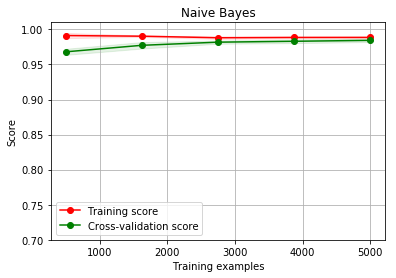

In [10]:
from sklearn.model_selection import learning_curve, ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MultinomialNB()
plot_learning_curve(estimator, 'Naive Bayes', transformed_train.toarray(),
                    train['label'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

Сходится красиво, аккуратно, без разбросов и скачков.

Далее функция для отобравжения roc-curve. При запуске компьютер завис, поэтому номера запусков такие неравномерные (пересчитывать-то долго..)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with

X = transformed_train.toarray()
#print(type(train['label']))
y = np.array(train['label'].values).reshape((len(train['label']),1))

# Binarize the output
#y = label_binarize(y, classes=[0, 1, 2])
#print(y.shape)
n_classes = y.shape[1]

# Add noisy features to make the problem harder
#random_state = np.random.RandomState(0)
random_state = 0
#n_samples, n_features = X.shape
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

#print(y_test)
change = {'spam':1, 'ham':0}
y_test = [change[y_test[i,0]] for i in range(0,len(y_test))]
y_test = np.array(y_test).reshape((len(y_test),1))

# Learn to predict each class against the other
classifier = OneVsRestClassifier(MultinomialNB())
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
#print(y_score[:,i])
#print(y_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(len(roc_auc))

# Compute micro-average ROC curve and ROC area
print(len(y_test), len(y_score))
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<class 'pandas.core.series.Series'>
(6250, 1)
1
3125 3125


ValueError: Found input variables with inconsistent numbers of samples: [3125, 6250]

In [ ]:
import scikitplot.plotters as skplt
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

clf = MultinomialNB()
change = {'spam':1, 'ham':0}

y_train = [change[lbl] for lbl in train['label']]

clf.fit(transformed_train, y_train)
print(transformed_train.shape, len(y_train))
y = [change[lbl] for lbl in train['label']]
#print(sum(y))
score = clf.predict(transformed_train).tolist()
#print(score)
roc_x = []
roc_y = []
min_score = min(score)
max_score = max(score)
thr = np.linspace(min_score, max_score, 30)
FP=0
TP=0
N = sum(y)
P = len(y) - N

for (i, T) in enumerate(thr):
    for i in range(0, len(score)):
        if (score[i] > T):
            if (y[i]==1):
                TP = TP + 1
            if (y[i]==0):
                FP = FP + 1
    roc_x.append(FP/float(N))
    roc_y.append(TP/float(P))
    FP=0
    TP=0
print(roc_x, roc_y)
plt.scatter(roc_x[:], roc_y[:])
plt.show()

# Задание 3

при запуске roc-кривой завис комп, пересчитывала все до нее, эту часть больше не трогала, но, вроде, она и так хороша)
Используем разделение на трейн и тест, которое было сделано еще в начале файла. 
Построим топ-20 частотных слов для каждого типа сообщений

In [11]:
import re
import itertools
from collections import Counter

didg = re.compile('[0-9]+')
upper_case_word = re.compile('[A-Z][a-z]+')
caps_word = re.compile('[A-Z]+')
excl = re.compile('!')
que = re.compile('\?')
comm = re.compile(',')
#mess_words = re.compile('[A-Za-z0-9]+')
#data_new = balansed_messages.copy()

words_spam = [line.split() for line in train.loc[train['label'] == 'spam']['message'].tolist()]
words_ham = [line.split() for line in train.loc[train['label'] == 'ham']['message'].tolist()]
words_spam = list(itertools.chain.from_iterable(words_spam))
words_ham = list(itertools.chain.from_iterable(words_ham))

d_dict_spam = Counter(words_spam)
d_dict_ham = Counter(words_ham)
print(d_dict_spam.most_common(20))
print(d_dict_ham.most_common(20))

[('to', 1962), ('a', 1185), ('your', 601), ('or', 599), ('the', 574), ('call', 573), ('2', 562), ('for', 554), ('you', 538), ('is', 468), ('Call', 439), ('on', 415), ('have', 399), ('and', 376), ('from', 374), ('ur', 346), ('with', 322), ('of', 313), ('&', 308), ('4', 306)]
[('to', 1232), ('I', 1195), ('you', 1189), ('the', 821), ('a', 784), ('and', 596), ('i', 590), ('in', 585), ('is', 513), ('u', 502), ('my', 497), ('me', 440), ('of', 397), ('for', 395), ('that', 328), ('it', 307), ('your', 302), ('have', 278), ('on', 278), ('be', 264)]


в принципе, частотные списки не особо различаются, поэтому, посмотрев на них, я добавлю только &
Выделим 10 параметров для каждого сообщения: 
количество чисел
количество слов с большой буквы
количество слов только заглавными буквами
количество !
количество ?
количество ,
количество &
средняя длина слова
длина сообщения
длина самого длинного слова
Кажется, что спам-сообщения написаны менее грамотно с точки зрения пунктуации, поэтому основной упор не нее

In [12]:
import statistics as st

amp = re.compile('&')
def extreact_features(line): #самое долнное слово, длина сообщения, средняя дляна слов
    #print(line)
    didg_count = len(didg.findall(line))
    upper_case_word_count = len(upper_case_word.findall(line))
    caps_word_count = len(caps_word.findall(line))
    excl_count = len(excl.findall(line))
    que_count = len(que.findall(line))
    comm_count = len(comm.findall(line))
    amp_count = len(amp.findall(line))
    len_words = [len(word[:]) for word in line.split()]
    mean_len = st.mean(len_words)
    max_len = max(len_words)
    len_line = len(line.split())
    return [didg_count, upper_case_word_count, caps_word_count,
            excl_count, que_count, comm_count, amp_count,
            mean_len, max_len, len_line]

def make_df(data):
    columns = ['didg_count', 'upper_case_word_count', 'caps_word_count',
                'excl_count', 'que_count', 'comm_count', 'amp_count',
                'mean_len', 'max_len', 'len_line']
    for col in columns:
        data[col] = pd.Series()
    #data = data.add(columns, axis='columns')
    i = 0
    for index, line in data.iterrows():
        data.loc[index, columns] = extreact_features(data.loc[index]['message'])
        # print(data.loc[index])
        print(len(data)-i)
        i += 1
    return data

#print(train['message'])
new_train = make_df(train)
evaluate = make_df(test)


/Users/Ksenia/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Ksenia/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


6250
6249
6248
6247
6246
6245
6244
6243
6242
6241
6240
6239
6238
6237
6236
6235
6234
6233
6232
6231
6230
6229
6228
6227
6226
6225
6224
6223
6222
6221
6220
6219
6218
6217
6216
6215
6214
6213
6212
6211
6210
6209
6208
6207
6206
6205
6204
6203
6202
6201
6200
6199
6198
6197
6196
6195
6194
6193
6192
6191
6190
6189
6188
6187
6186
6185
6184
6183
6182
6181
6180
6179
6178
6177
6176
6175
6174
6173
6172
6171
6170
6169
6168
6167
6166
6165
6164
6163
6162
6161
6160
6159
6158
6157
6156
6155
6154
6153
6152
6151
6150
6149
6148
6147
6146
6145
6144
6143
6142
6141
6140
6139
6138
6137
6136
6135
6134
6133
6132
6131
6130
6129
6128
6127
6126
6125
6124
6123
6122
6121
6120
6119
6118
6117
6116
6115
6114
6113
6112
6111
6110
6109
6108
6107
6106
6105
6104
6103
6102
6101
6100
6099
6098
6097
6096
6095
6094
6093
6092
6091
6090
6089
6088
6087
6086
6085
6084
6083
6082
6081
6080
6079
6078
6077
6076
6075
6074
6073
6072
6071
6070
6069
6068
6067
6066
6065
6064
6063
6062
6061
6060
6059
6058
6057
6056
6055
6054
6053
6052
6051


Тестовую выборку из предыдущего деления будем рассматривать как evaluation, поэтому для выбора модели нужно еще раз поделить test

In [13]:
to_train, to_test = train_test_split(train, test_size=0.1, random_state=12)

как и для bag of words, сделаем бейзлайн-классификатор и обучим модели рандомного леса, байеса и дерева решений

In [14]:
from sklearn.dummy import DummyClassifier

columns = ['didg_count', 'upper_case_word_count', 'caps_word_count',
            'excl_count', 'que_count', 'comm_count', 'amp_count',
            'mean_len', 'max_len', 'len_line']
dc = DummyClassifier()
dc.fit(to_train[columns], to_train['label'])

print(classification_report(to_test['label'], dc.predict(to_test[columns]), target_names=['spam', 'ham']))

             precision    recall  f1-score   support

       spam       0.62      0.62      0.62       389
        ham       0.38      0.38      0.38       236

avg / total       0.53      0.53      0.53       625



In [15]:
clf = MultinomialNB()
clf.fit(to_train[columns], to_train['label'])
print(classification_report(to_test['label'], clf.predict(to_test[columns]), target_names=['spam', 'ham']))

             precision    recall  f1-score   support

       spam       0.92      0.92      0.92       389
        ham       0.87      0.87      0.87       236

avg / total       0.90      0.90      0.90       625



In [16]:
#train DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(to_train[columns], to_train['label'])
print(classification_report(to_test['label'], dtc.predict(to_test[columns]), target_names=['spam', 'ham']))

#train RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(to_train[columns], to_train['label'])
print(classification_report(to_test['label'], rfc.predict(to_test[columns]), target_names=['spam', 'ham']))

             precision    recall  f1-score   support

       spam       1.00      0.97      0.99       389
        ham       0.96      1.00      0.98       236

avg / total       0.98      0.98      0.98       625

             precision    recall  f1-score   support

       spam       1.00      0.98      0.99       389
        ham       0.97      1.00      0.98       236

avg / total       0.99      0.99      0.99       625



Прверим лучшую модель на проверочной выборке (как в "реальном мире", обучимся на полной доступной вборке - всем тренйне и проверим на изначальном тесте)

In [37]:
rfc = RandomForestClassifier()
rfc.fit(train[columns], train['label'])
print(classification_report(test['label'], rfc.predict(test[columns]), target_names=['spam', 'ham']))

             precision    recall  f1-score   support

       spam       1.00      0.99      0.99       973
        ham       0.98      0.99      0.99       590

avg / total       0.99      0.99      0.99      1563



В принципе, модель хорошо обучениа, так как на эвалюэйте показывает результат не хуже, чем на тесте.
Построим матрицу ошибок для разных выборок.

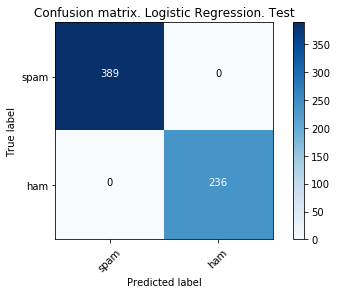

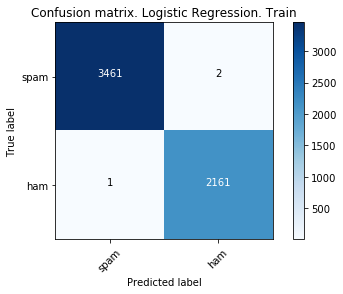

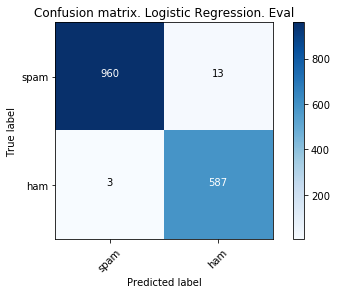

In [38]:
from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

mat = confusion_matrix(to_test['label'], rfc.predict(to_test[columns]))
plt.figure(1)
plot_confusion_matrix(mat, classes=['spam', 'ham'],
                        title='Confusion matrix. Logistic Regression. Test')
matr = confusion_matrix(to_train['label'], rfc.predict(to_train[columns]))
plt.show()
plt.figure(2)
plot_confusion_matrix(matr, classes=['spam', 'ham'],
                      title='Confusion matrix. Logistic Regression. Train')

matr = confusion_matrix(test['label'], rfc.predict(test[columns]))
plt.show()
plt.figure(3)
plot_confusion_matrix(matr, classes=['spam', 'ham'],
                      title='Confusion matrix. Logistic Regression. Eval')
plt.show()

как видно из матрицы ошибок и отчетов, натренированные алгоритмы работают отлично! Интересно, что пунктуация и оформление слов заглавными буквами дали на выходе практически не уступающую векторам точность.
Интересно было сравнить модели, обученные только на векторизации и только на выделенных фичах, поэтому в задании 3 не векторизовала.